<a href="https://colab.research.google.com/github/wu-warren/Benign-Overfitting-Robustness-Tradeoff/blob/main/Adversarial_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from tqdm import tqdm, trange

from matplotlib import pyplot as plt
import numpy as np

In [ ]:
a = torch.randn(1000,1000)

device = torch.device("cuda")
a_cuda = a.to(device) # copying the matrix from cpu to gpu

In [ ]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='.', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='.', train=False, transform=transform, download=True)

# Dataloader is used for mini-batch gradient descent. It does the job of shuffling the data and put data into batches
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.60MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.93MB/s]


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 2000), # benign overfitting: a lot of neurons
            nn.ReLU(),
            nn.Linear(2000, 10)
        )
        # you have a few options for the last layer
        # softmax, log_softmax, or just linear
        # different loss functions expect different outputs

    def forward(self, x):
        return self.net(x)

model = Net()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device) # move model to gpu

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [ ]:
history_loss = []

for epoch in trange(5):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) # move input and output to gpu
        preds = model(images)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # print(f"Epoch {epoch+1} complete")
    history_loss.append(loss.item())

100%|██████████| 5/5 [00:39<00:00,  7.96s/it]


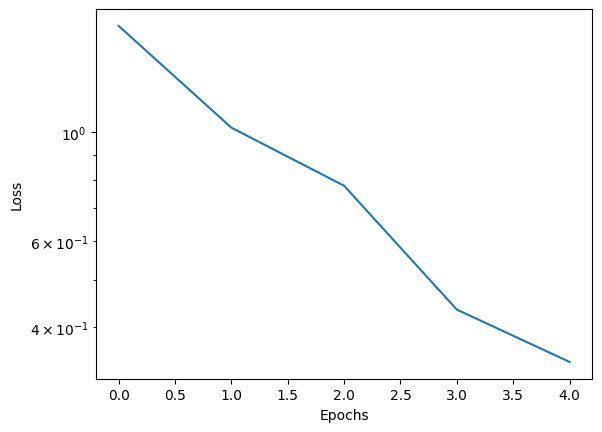

In [ ]:
plt.plot(history_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

Weight Decayed Model

In [ ]:
weight_decay_model = Net()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weight_decay_model = Net().to(device) # move model to gpu

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(weight_decay_model.parameters(), lr=0.001, weight_decay = 1e-1) # change this value to make regularization stronger

In [ ]:
history_loss = []

for epoch in trange(5):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) # move input and output to gpu
        preds = weight_decay_model(images)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # print(f"Epoch {epoch+1} complete")
    history_loss.append(loss.item())

100%|██████████| 5/5 [00:39<00:00,  7.83s/it]


Introducing Adversarial Attack

In [ ]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

In [ ]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = denorm(data)

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        # Reapply normalization
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        # Re-classify the perturbed image
        output = model(perturbed_data_normalized)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [ ]:
# changed this to a function btw, probably should clean up parameters and such
def adversarial_test(model):
  accuracies = []
  examples = []
  epsilons = [0, .05, .1, .15, .2, .25, .3]

  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

  # Run test for each epsilon
  for eps in epsilons:
      acc, ex = test(model, device, test_loader, eps)
      accuracies.append(acc)
      examples.append(ex)

adversarial_test(model)

Epsilon: 0	Test Accuracy = 8759 / 10000 = 0.8759
Epsilon: 0.05	Test Accuracy = 755 / 10000 = 0.0755
Epsilon: 0.1	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.15	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.2	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.25	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.3	Test Accuracy = 0 / 10000 = 0.0


In [ ]:
adversarial_test(weight_decay_model) # looks like higher regularization parameter makes the model better against adversarial data--not good, but better

Epsilon: 0	Test Accuracy = 8456 / 10000 = 0.8456
Epsilon: 0.05	Test Accuracy = 2124 / 10000 = 0.2124
Epsilon: 0.1	Test Accuracy = 15 / 10000 = 0.0015
Epsilon: 0.15	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.2	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.25	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.3	Test Accuracy = 0 / 10000 = 0.0


In [ ]:
def adversarial_train(model, device, train_loader, optimizer, criterion,
                      epsilon, epochs):
    history_loss = []
    model.train()

    for epoch in trange(epochs, desc="FGSM Adversarial Training Epoch"):
        total_loss = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            images.requires_grad = True

            output = model(images)
            loss_for_grad = criterion(output, labels)

            model.zero_grad()
            loss_for_grad.backward()
            data_grad = images.grad.data

            # The magic numbers are mean and std of the MNSIT data set
            perturbed_images = transforms.Normalize((0.1307,), (0.3081,))(
                fgsm_attack(denorm(images), epsilon, data_grad)
            )

            preds = model(perturbed_images)
            loss = criterion(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        history_loss.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} - FGSM Adversarial Loss: {avg_loss}")

    return history_loss


In [ ]:
adverse_model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(adverse_model.parameters(), lr=0.001)

ADV_EPSILON = 0.1         # Can play around with this number
TRAIN_EPOCHS = 5

adversarial_history_loss = adversarial_train(
    model=adverse_model,
    device=device,
    train_loader=train_loader,
    optimizer=optimizer,
    criterion=criterion,
    epsilon=ADV_EPSILON,
    epochs=TRAIN_EPOCHS
)

FGSM Adversarial Training Epoch:  20%|██        | 1/5 [00:10<00:42, 10.56s/it]

Epoch 1/5 - FGSM Adversarial Loss: 2.7098217487335203


FGSM Adversarial Training Epoch:  40%|████      | 2/5 [00:20<00:30, 10.29s/it]

Epoch 2/5 - FGSM Adversarial Loss: 2.384699422073364


FGSM Adversarial Training Epoch:  40%|████      | 2/5 [00:24<00:37, 12.44s/it]


KeyboardInterrupt: 

In [ ]:
plt.plot(adversarial_history_loss)
plt.xlabel('Epochs')
plt.ylabel('Adversarial Loss')
plt.yscale('log')
plt.title('Adversarial Training Loss over Epochs')
plt.show()

In [ ]:
adversarial_test(adverse_model)

In [ ]:


adverse_weight_decay_model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(adverse_model.parameters(), lr=0.001)

ADV_EPSILON = 0.1         # Can play around with this number
TRAIN_EPOCHS = 5

adversarial_history_loss = adversarial_train(
    model=adverse_weight_decay_model,
    device=device,
    train_loader=train_loader,
    optimizer=optimizer,
    criterion=criterion,
    epsilon=ADV_EPSILON,
    epochs=TRAIN_EPOCHS
)